Processing timestep 12...
Processing timestep 13...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/3365801651.py:82: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_data, axis=0)


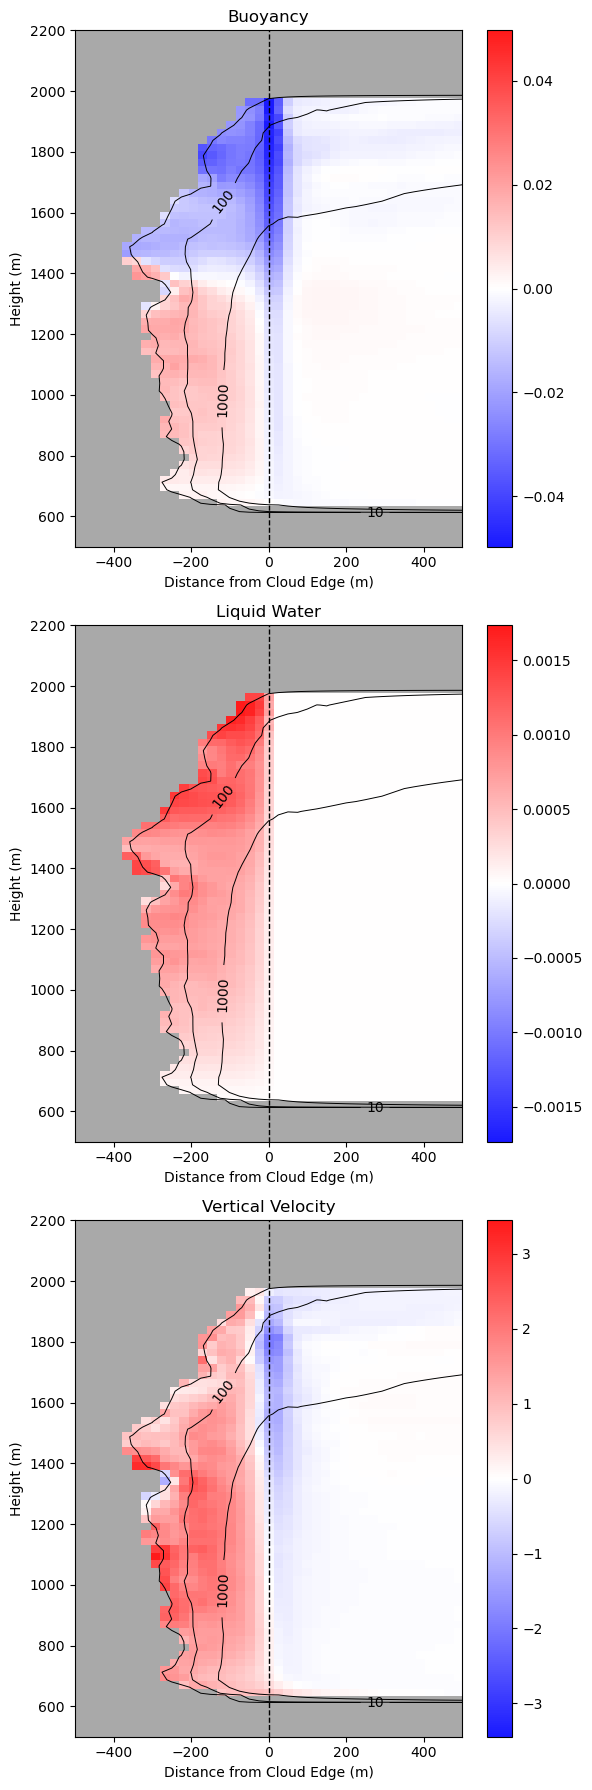

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_cdt, binary_erosion
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.colors import TwoSlopeNorm

# Constants
horizontal_resolution = 25  # Horizontal resolution in meters

# File paths and variable names
data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
files = {
    'w': data_dir + 'rico.w.nc',
    'l': data_dir + 'rico.l.nc',
    'b': data_dir + 'rico.buoyancy.nc',  # Buoyancy file
    't': data_dir + 'rico.t.nc'          # Temperature file (contains 'zt')
}
var_names = {
    'w': 'w',
    'l': 'l',
    'b': 'buoyancy',
    't': 't'
}

def load_data(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep].astype(np.float64)
        return data  # Units are assumed to be correct

def load_zt(filename):
    with nc.Dataset(filename) as ds:
        return ds['zt'][:]

def calculate_values_vs_distance(buoyancy_data, liquid_water_data, w_data, cloud_mask, max_distance):
    """Calculate values as a function of distance from cloud edge."""
    height_levels, ny, nx = buoyancy_data.shape
    total_distance = 2 * max_distance + 1
    results = {var: np.full((height_levels, total_distance), np.nan) for var in ['buoyancy', 'liquid_water', 'w']}
    results['cloud_count'] = np.zeros((height_levels, total_distance), dtype=int)

    for z in range(height_levels):
        mask = cloud_mask[z]
        if mask.any():
            dist_out = distance_transform_cdt(~mask, metric='taxicab')
            dist_in = distance_transform_cdt(mask, metric='taxicab')
            distances = np.where(mask, -dist_in + 1, dist_out)

            # Identify cloud edges and set distance to 0
            eroded_mask = binary_erosion(mask)
            cloud_edge = mask & ~eroded_mask
            distances[cloud_edge] = 0

            for d in range(-max_distance, max_distance + 1):
                idx = np.where(distances == d)
                if idx[0].size > 0:
                    pos = d + max_distance
                    results['buoyancy'][z, pos] = np.mean(buoyancy_data[z, idx[0], idx[1]])
                    results['liquid_water'][z, pos] = np.mean(liquid_water_data[z, idx[0], idx[1]])
                    results['w'][z, pos] = np.mean(w_data[z, idx[0], idx[1]])
                    results['cloud_count'][z, pos] += idx[0].size
    return results

def process_timesteps(timesteps, max_distance):
    all_results = []
    for timestep in timesteps:
        print(f"Processing timestep {timestep}...")
        b_data = load_data(files['b'], var_names['b'], timestep)
        l_data = load_data(files['l'], var_names['l'], timestep)
        w_data = load_data(files['w'], var_names['w'], timestep)

        cloud_mask = l_data > 1e-5  # Threshold for cloud presence
        results = calculate_values_vs_distance(b_data, l_data, w_data, cloud_mask, max_distance)
        all_results.append(results)

    mean_results = {}
    for key in all_results[0]:
        stacked_data = np.array([res[key] for res in all_results])
        if key == 'cloud_count':
            mean_results[key] = np.sum(stacked_data, axis=0)
        else:
            mean_results[key] = np.nanmean(stacked_data, axis=0)
    return mean_results

# Parameters
timesteps = list(range(12, 14))
max_distance_meters = 500
max_distance = max_distance_meters // horizontal_resolution
distance_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# Process data
mean_results = process_timesteps(timesteps, max_distance)
zt_values = load_zt(files['t'])  # Load 'zt' from the temperature file

# Plotting
variables = ['buoyancy', 'liquid_water', 'w']
titles = ['Buoyancy', 'Liquid Water', 'Vertical Velocity']


fig, axs = plt.subplots(3, 1, figsize=(6, 18))

for ax, var, title in zip(axs, variables, titles):
    data = np.ma.masked_invalid(mean_results[var])

    # Colormap settings
    cmap = plt.get_cmap('bwr')
    cmap = cmap(np.linspace(0, 1, cmap.N))
    cmap[:, -1] = 0.9  # Transparency
    cmap = ListedColormap(cmap)
    cmap.set_bad(color='darkgrey')

    # Normalize using TwoSlopeNorm to center at 0
    vmin_data = np.nanmin(data)
    vmax_data = np.nanmax(data)
    vmax_abs = max(abs(vmin_data), abs(vmax_data))
    norm = TwoSlopeNorm(vcenter=0, vmin=-vmax_abs, vmax=vmax_abs)

    # Plot
    im = ax.imshow(
        data,
        cmap=cmap,
        norm=norm,
        origin='lower',
        aspect='auto',
        extent=[distance_meters[0], distance_meters[-1], zt_values[0], zt_values[-1]]
    )
    ax.set_title(title)
    ax.set_xlabel('Distance from Cloud Edge (m)')
    ax.set_ylabel('Height (m)')
    ax.set_ylim(500, 2200)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    fig.colorbar(im, ax=ax)

    # Contours
    cloud_count = mean_results['cloud_count']
    levels = [10, 100, 1000]
    cs = ax.contour(
        distance_meters,
        zt_values,
        cloud_count,
        levels=levels,
        colors='black',
        linewidths=0.7
    )
    ax.clabel(cs, fmt='%d')

plt.tight_layout()
plt.show()

# Difference to the domain mean

Processing timestep 3...
Processing timestep 4...
Processing timestep 5...
Processing timestep 6...
Processing timestep 7...
Processing timestep 8...
Processing timestep 9...
Processing timestep 10...
Processing timestep 11...
Processing timestep 12...
Processing timestep 13...
Processing timestep 14...
Processing timestep 15...
Processing timestep 16...
Processing timestep 17...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/3291663245.py:104: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_data, axis=0)


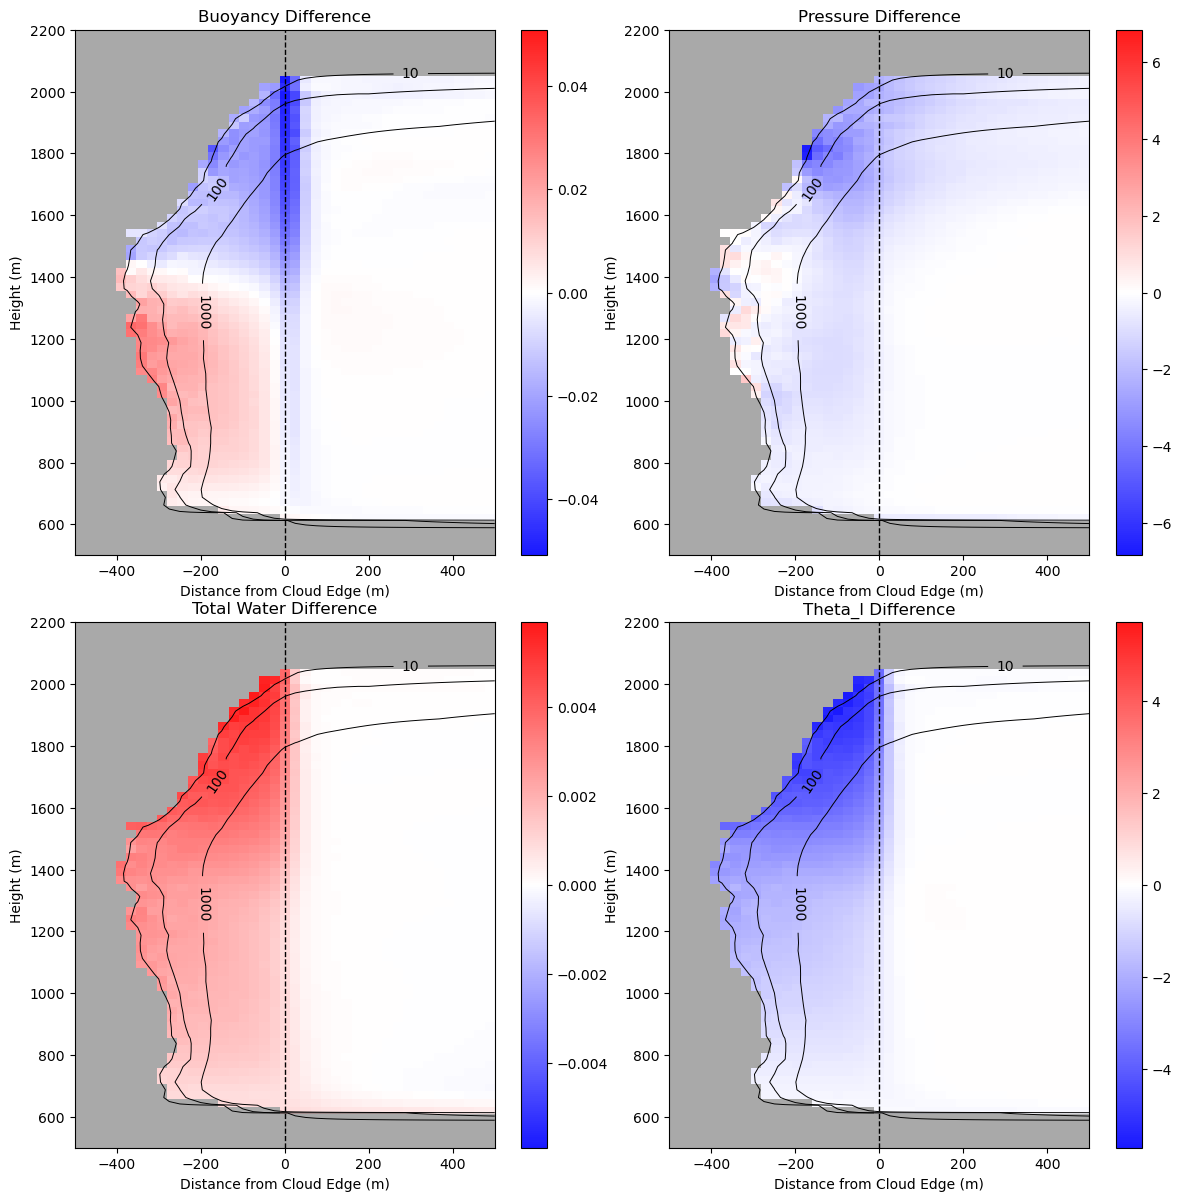

In [6]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_cdt, binary_erosion
from matplotlib.colors import Normalize, ListedColormap, TwoSlopeNorm

# Constants
horizontal_resolution = 25  # Horizontal resolution in meters

# File paths and variable names
data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
files = {
    'p': data_dir + 'rico.p.nc',          # Pressure file
    'q': data_dir + 'rico.q.nc',          # Total water content
    't': data_dir + 'rico.t.nc',          # Theta_l (liquid water potential temperature)
    'b': data_dir + 'rico.buoyancy.nc',   # Buoyancy file
    'l': data_dir + 'rico.l.nc',          # Liquid water content (for cloud mask)
}

var_names = {
    'p': 'p',
    'q': 'q',
    't': 't',
    'b': 'buoyancy',
    'l': 'l',
}

def load_data(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep].astype(np.float64)
        return data  # Units are assumed to be correct

def load_zt(filename):
    with nc.Dataset(filename) as ds:
        return ds['zt'][:]

def calculate_values_vs_distance(data_dict, cloud_mask, max_distance):
    """Calculate values as a function of distance from cloud edge."""
    # data_dict: dictionary of data arrays for variables
    height_levels, ny, nx = next(iter(data_dict.values())).shape
    total_distance = 2 * max_distance + 1
    variables = list(data_dict.keys())
    results = {var: np.full((height_levels, total_distance), np.nan) for var in variables}
    results['cloud_count'] = np.zeros((height_levels, total_distance), dtype=int)

    for z in range(height_levels):
        mask = cloud_mask[z]
        if mask.any():
            dist_out = distance_transform_cdt(~mask, metric='taxicab')
            dist_in = distance_transform_cdt(mask, metric='taxicab')
            distances = np.where(mask, -dist_in + 1, dist_out)

            # Identify cloud edges and set distance to 0
            eroded_mask = binary_erosion(mask)
            cloud_edge = mask & ~eroded_mask
            distances[cloud_edge] = 0

            for d in range(-max_distance, max_distance + 1):
                idx = np.where(distances == d)
                if idx[0].size > 0:
                    pos = d + max_distance
                    for var in variables:
                        results[var][z, pos] = np.mean(data_dict[var][z, idx[0], idx[1]])
                    results['cloud_count'][z, pos] += idx[0].size
    return results

def process_timesteps(timesteps, max_distance):
    all_results = []
    for timestep in timesteps:
        print(f"Processing timestep {timestep}...")
        # Load data
        b_data = load_data(files['b'], var_names['b'], timestep)
        p_data = load_data(files['p'], var_names['p'], timestep)
        q_data = load_data(files['q'], var_names['q'], timestep)
        t_data = load_data(files['t'], var_names['t'], timestep)
        l_data = load_data(files['l'], var_names['l'], timestep)

        # Create cloud mask
        cloud_mask = l_data > 1e-5  # Threshold for cloud presence

        # Compute domain-wide mean at each vertical level for each variable
        variables = {'b': b_data, 'p': p_data, 'q': q_data, 't': t_data}
        domain_means = {}
        for var, data in variables.items():
            domain_means[var] = np.mean(data, axis=(1, 2))  # Mean over y and x dimensions

        # Compute difference from domain-wide mean at each point
        data_diff = {}
        for var, data in variables.items():
            # Reshape domain mean to broadcast over y and x dimensions
            mean_reshaped = domain_means[var][:, np.newaxis, np.newaxis]
            data_diff[var] = data - mean_reshaped

        # Prepare data_dict for calculate_values_vs_distance
        results = calculate_values_vs_distance(data_diff, cloud_mask, max_distance)
        all_results.append(results)

    mean_results = {}
    for key in all_results[0]:
        stacked_data = np.array([res[key] for res in all_results])
        if key == 'cloud_count':
            mean_results[key] = np.sum(stacked_data, axis=0)
        else:
            mean_results[key] = np.nanmean(stacked_data, axis=0)
    return mean_results

# Parameters
timesteps = list(range(12, 14))
max_distance_meters = 500
max_distance = max_distance_meters // horizontal_resolution
distance_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# Process data
mean_results = process_timesteps(timesteps, max_distance)
zt_values = load_zt(files['t'])  # Load 'zt' from the temperature file

# Plotting
variables = ['b', 'p', 'q', 't']
titles = ['Buoyancy Difference', 'Pressure Difference', 'Total Water Difference', 'Theta_l Difference']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for ax, var, title in zip(axs.flat, variables, titles):
    data = np.ma.masked_invalid(mean_results[var])

    # Colormap settings
    cmap = plt.get_cmap('bwr')
    cmap = cmap(np.linspace(0, 1, cmap.N))
    cmap[:, -1] = 0.9  # Transparency
    cmap = ListedColormap(cmap)
    cmap.set_bad(color='darkgrey')

    # Normalize using TwoSlopeNorm to center at 0
    vmin_data = np.nanmin(data)
    vmax_data = np.nanmax(data)
    vmax_abs = max(abs(vmin_data), abs(vmax_data))
    norm = TwoSlopeNorm(vcenter=0, vmin=-vmax_abs, vmax=vmax_abs)

    # Plot
    im = ax.imshow(
        data,
        cmap=cmap,
        norm=norm,
        origin='lower',
        aspect='auto',
        extent=[distance_meters[0], distance_meters[-1], zt_values[0], zt_values[-1]]
    )
    ax.set_title(title)
    ax.set_xlabel('Distance from Cloud Edge (m)')
    ax.set_ylabel('Height (m)')
    ax.set_ylim(500, 2200)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    fig.colorbar(im, ax=ax)

    # Contours
    cloud_count = mean_results['cloud_count']
    levels = [10, 100, 1000]
    cs = ax.contour(
        distance_meters,
        zt_values,
        cloud_count,
        levels=levels,
        colors='black',
        linewidths=0.7
    )
    ax.clabel(cs, fmt='%d')
#fig.savefig('near_env_domain_difference.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


# Vertically averaged deviation

Processing timestep 12...
Processing timestep 13...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/2803454639.py:98: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_data, axis=0)
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/2803454639.py:122: RuntimeWarning: Mean of empty slice
  vertically_averaged_mean[var] = np.nanmean(data, axis=0)  # Shape: (total_distance,)


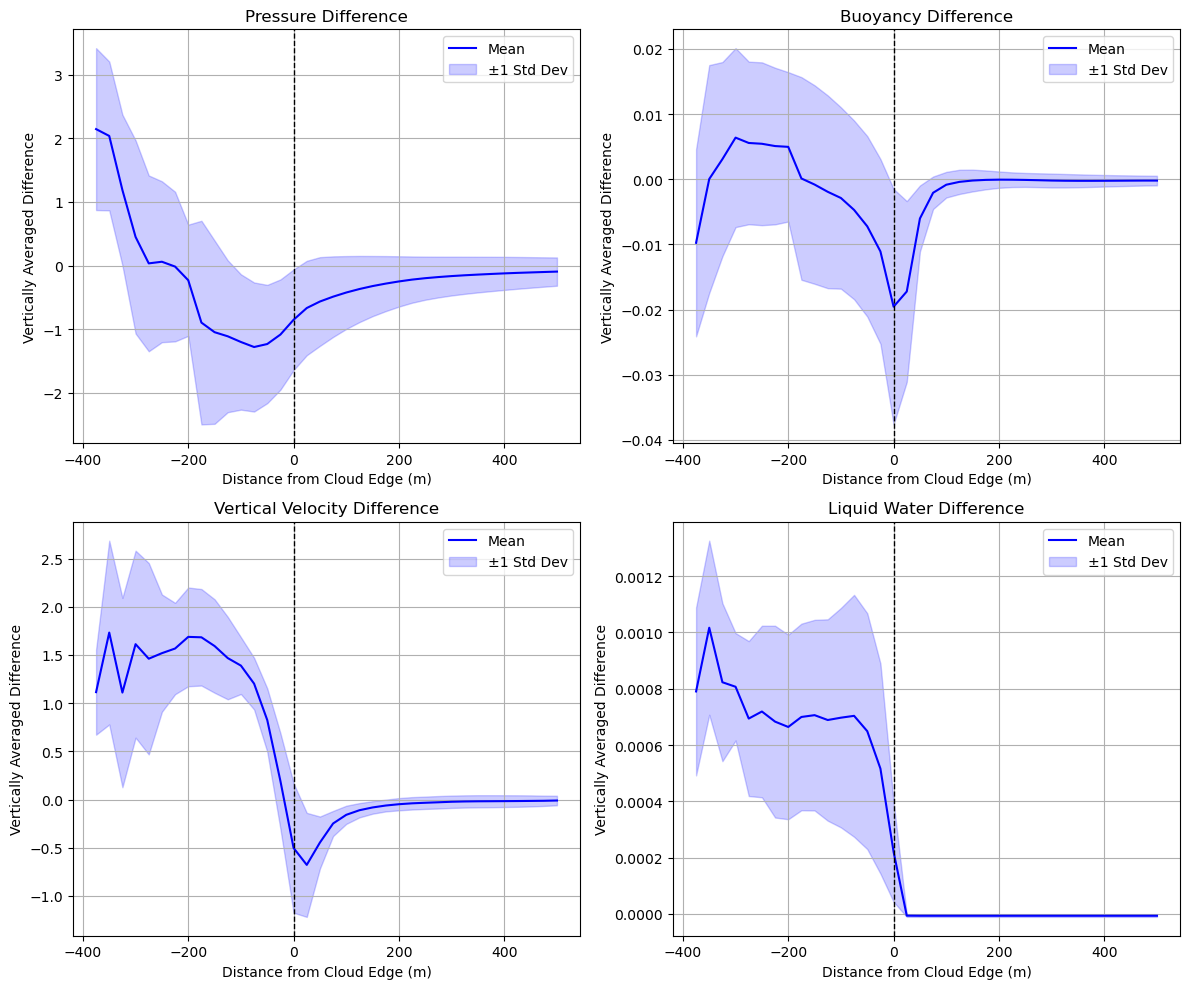

In [8]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_cdt, binary_erosion

# Constants
horizontal_resolution = 25  # Horizontal resolution in meters

# File paths and variable names
data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
files = {
    'p': data_dir + 'rico.p.nc',          # Pressure file
    'b': data_dir + 'rico.buoyancy.nc',   # Buoyancy file
    'w': data_dir + 'rico.w.nc',          # Vertical velocity file
    'l': data_dir + 'rico.l.nc',          # Liquid water content (for cloud mask and variable)
}

var_names = {
    'p': 'p',
    'b': 'buoyancy',
    'w': 'w',
    'l': 'l',
}

def load_data(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep].astype(np.float64)
        return data  # Units are assumed to be correct

def calculate_values_vs_distance(data_dict, cloud_mask, max_distance):
    """Calculate values as a function of distance from cloud edge."""
    # data_dict: dictionary of data arrays for variables
    height_levels, ny, nx = next(iter(data_dict.values())).shape
    total_distance = 2 * max_distance + 1
    variables = list(data_dict.keys())
    results = {var: np.full((height_levels, total_distance), np.nan) for var in variables}
    results['cloud_count'] = np.zeros((height_levels, total_distance), dtype=int)

    for z in range(height_levels):
        mask = cloud_mask[z]
        if mask.any():
            dist_out = distance_transform_cdt(~mask, metric='taxicab')
            dist_in = distance_transform_cdt(mask, metric='taxicab')
            distances = np.where(mask, -dist_in + 1, dist_out)

            # Identify cloud edges and set distance to 0
            eroded_mask = binary_erosion(mask)
            cloud_edge = mask & ~eroded_mask
            distances[cloud_edge] = 0

            for d in range(-max_distance, max_distance + 1):
                idx = np.where(distances == d)
                if idx[0].size > 0:
                    pos = d + max_distance
                    for var in variables:
                        results[var][z, pos] = np.mean(data_dict[var][z, idx[0], idx[1]])
                    results['cloud_count'][z, pos] += idx[0].size
    return results

def process_timesteps(timesteps, max_distance):
    all_results = []
    for timestep in timesteps:
        print(f"Processing timestep {timestep}...")
        # Load data
        b_data = load_data(files['b'], var_names['b'], timestep)
        p_data = load_data(files['p'], var_names['p'], timestep)
        w_data = load_data(files['w'], var_names['w'], timestep)
        l_data = load_data(files['l'], var_names['l'], timestep)

        # Create cloud mask
        cloud_mask = l_data > 1e-5  # Threshold for cloud presence

        # Compute domain-wide mean at each vertical level for each variable
        variables = {'p': p_data, 'b': b_data, 'w': w_data, 'l': l_data}
        domain_means = {}
        for var, data in variables.items():
            domain_means[var] = np.mean(data, axis=(1, 2))  # Mean over y and x dimensions

        # Compute difference from domain-wide mean at each point
        data_diff = {}
        for var, data in variables.items():
            # Reshape domain mean to broadcast over y and x dimensions
            mean_reshaped = domain_means[var][:, np.newaxis, np.newaxis]
            data_diff[var] = data - mean_reshaped

        # Prepare data_dict for calculate_values_vs_distance
        results = calculate_values_vs_distance(data_diff, cloud_mask, max_distance)
        all_results.append(results)

    # Initialize dictionaries to store mean and standard deviation
    mean_results = {}
    std_results = {}
    for key in all_results[0]:
        stacked_data = np.array([res[key] for res in all_results])
        if key == 'cloud_count':
            mean_results[key] = np.sum(stacked_data, axis=0)
        else:
            mean_results[key] = np.nanmean(stacked_data, axis=0)
            std_results[key] = np.nanstd(stacked_data, axis=0)  # Calculate standard deviation
    return mean_results, std_results

# Parameters
timesteps = list(range(12, 14))
max_distance_meters = 500
max_distance = max_distance_meters // horizontal_resolution
distance_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# Process data
mean_results, std_results = process_timesteps(timesteps, max_distance)

# Variables to plot
variables = ['p', 'b', 'w', 'l']
titles = ['Pressure Difference', 'Buoyancy Difference', 'Vertical Velocity Difference', 'Liquid Water Difference']

# Calculate vertically averaged mean differences and standard deviations
vertically_averaged_mean = {}
vertically_averaged_std = {}
for var in variables:
    data = mean_results[var]  # Shape: (height_levels, total_distance)
    std_data = std_results[var]  # Shape: (height_levels, total_distance)
    # Compute mean and standard deviation over height levels
    vertically_averaged_mean[var] = np.nanmean(data, axis=0)  # Shape: (total_distance,)
    vertically_averaged_std[var] = np.nanstd(data, axis=0)    # Shape: (total_distance,)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for ax, var, title in zip(axs.flat, variables, titles):
    y_mean = vertically_averaged_mean[var]
    y_std = vertically_averaged_std[var]
    x_data = distance_meters

    # Plot mean line
    ax.plot(x_data, y_mean, color='blue', label='Mean')

    # Plot shaded area for ±1 standard deviation
    ax.fill_between(x_data, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='±1 Std Dev')

    ax.set_title(title)
    ax.set_xlabel('Distance from Cloud Edge (m)')
    ax.set_ylabel('Vertically Averaged Difference')
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


## Weighted mean!!!


Processing timestep 3...
Processing timestep 4...
Processing timestep 5...
Processing timestep 6...
Processing timestep 7...
Processing timestep 8...
Processing timestep 9...
Processing timestep 10...
Processing timestep 11...
Processing timestep 12...
Processing timestep 13...
Processing timestep 14...
Processing timestep 15...
Processing timestep 16...
Processing timestep 17...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/1696274722.py:98: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_data, axis=0)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/1696274722.py:129: RuntimeWarning: invalid value encountered in divide
  weighted_mean = numerator / denominator
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_26399/1696274722.py:142: RuntimeWarning: invalid value encountered in divide
  weighted_variance = variance_numerator / variance_denominator


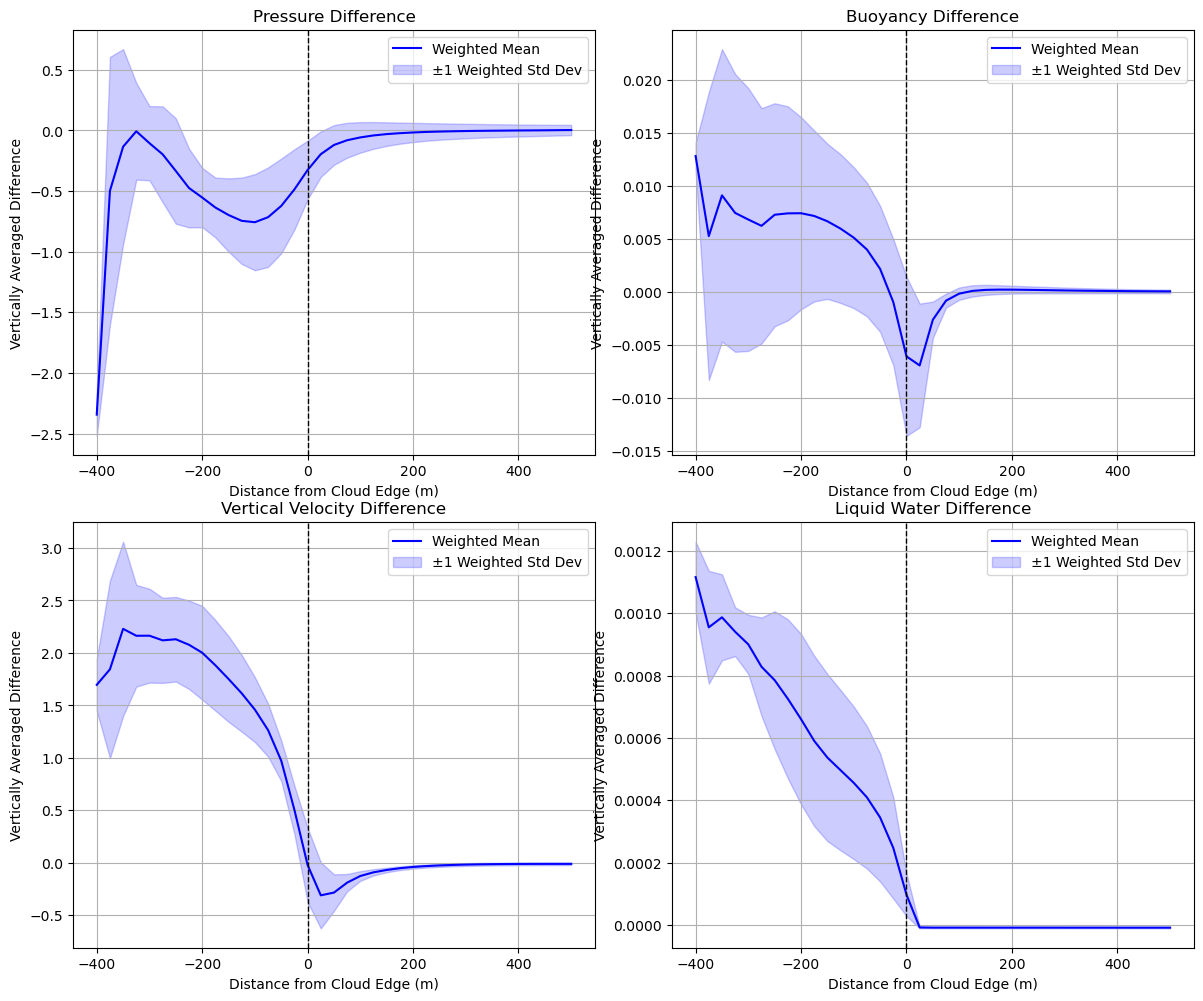

In [10]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt
# from scipy.ndimage import distance_transform_cdt, binary_erosion

# # Constants
# horizontal_resolution = 25  # Horizontal resolution in meters

# # File paths and variable names
# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'
# files = {
#     'p': data_dir + 'rico.p.nc',          # Pressure file
#     'b': data_dir + 'rico.buoyancy.nc',   # Buoyancy file
#     'w': data_dir + 'rico.w.nc',          # Vertical velocity file
#     'l': data_dir + 'rico.l.nc',          # Liquid water content (for cloud mask and variable)
# }

# var_names = {
#     'p': 'p',
#     'b': 'buoyancy',
#     'w': 'w',
#     'l': 'l',
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         data = ds[var_name][timestep].astype(np.float64)
#         return data  # Units are assumed to be correct

# def calculate_values_vs_distance(data_dict, cloud_mask, max_distance):
#     """Calculate values as a function of distance from cloud edge."""
#     # data_dict: dictionary of data arrays for variables
#     height_levels, ny, nx = next(iter(data_dict.values())).shape
#     total_distance = 2 * max_distance + 1
#     variables = list(data_dict.keys())
#     results = {var: np.full((height_levels, total_distance), np.nan) for var in variables}
#     results['cloud_count'] = np.zeros((height_levels, total_distance), dtype=int)

#     for z in range(height_levels):
#         mask = cloud_mask[z]
#         if mask.any():
#             dist_out = distance_transform_cdt(~mask, metric='taxicab')
#             dist_in = distance_transform_cdt(mask, metric='taxicab')
#             distances = np.where(mask, -dist_in + 1, dist_out)

#             # Identify cloud edges and set distance to 0
#             eroded_mask = binary_erosion(mask)
#             cloud_edge = mask & ~eroded_mask
#             distances[cloud_edge] = 0

#             for d in range(-max_distance, max_distance + 1):
#                 idx = np.where(distances == d)
#                 if idx[0].size > 0:
#                     pos = d + max_distance
#                     for var in variables:
#                         results[var][z, pos] = np.mean(data_dict[var][z, idx[0], idx[1]])
#                     results['cloud_count'][z, pos] += idx[0].size
#     return results

# def process_timesteps(timesteps, max_distance):
#     all_results = []
#     for timestep in timesteps:
#         print(f"Processing timestep {timestep}...")
#         # Load data
#         b_data = load_data(files['b'], var_names['b'], timestep)
#         p_data = load_data(files['p'], var_names['p'], timestep)
#         w_data = load_data(files['w'], var_names['w'], timestep)
#         l_data = load_data(files['l'], var_names['l'], timestep)

#         # Create cloud mask
#         cloud_mask = l_data > 1e-5  # Threshold for cloud presence

#         # Compute domain-wide mean at each vertical level for each variable
#         variables = {'p': p_data, 'b': b_data, 'w': w_data, 'l': l_data}
#         domain_means = {}
#         for var, data in variables.items():
#             domain_means[var] = np.mean(data, axis=(1, 2))  # Mean over y and x dimensions

#         # Compute difference from domain-wide mean at each point
#         data_diff = {}
#         for var, data in variables.items():
#             # Reshape domain mean to broadcast over y and x dimensions
#             mean_reshaped = domain_means[var][:, np.newaxis, np.newaxis]
#             data_diff[var] = data - mean_reshaped

#         # Prepare data_dict for calculate_values_vs_distance
#         results = calculate_values_vs_distance(data_diff, cloud_mask, max_distance)
#         all_results.append(results)

#     # Initialize dictionaries to store mean and standard deviation
#     mean_results = {}
#     std_results = {}
#     for key in all_results[0]:
#         stacked_data = np.array([res[key] for res in all_results])
#         if key == 'cloud_count':
#             mean_results[key] = np.sum(stacked_data, axis=0)
#         else:
#             mean_results[key] = np.nanmean(stacked_data, axis=0)
#             std_results[key] = np.nanstd(stacked_data, axis=0)  # Calculate standard deviation
#     return mean_results, std_results

# # Parameters
# timesteps = list(range(2, 14))
# max_distance_meters = 500
# max_distance = max_distance_meters // horizontal_resolution
# distance_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# # Process data
# mean_results, std_results = process_timesteps(timesteps, max_distance)

# # Variables to plot
# variables = ['p', 'b', 'w', 'l']
# titles = ['Pressure Difference', 'Buoyancy Difference', 'Vertical Velocity Difference', 'Liquid Water Difference']

# # Calculate vertically averaged weighted mean differences and standard deviations
# vertically_averaged_mean = {}
# vertically_averaged_std = {}

# for var in variables:
#     data = mean_results[var]  # Shape: (height_levels, total_distance)
#     counts = mean_results['cloud_count']  # Shape: (height_levels, total_distance)
#     # Replace zeros with np.nan to avoid division by zero
#     counts_with_nan = counts.astype(np.float64)
#     counts_with_nan[counts_with_nan == 0] = np.nan

#     # Compute weighted mean over height levels
#     numerator = np.nansum(data * counts_with_nan, axis=0)  # Sum over height levels
#     denominator = np.nansum(counts_with_nan, axis=0)  # Sum over height levels
#     weighted_mean = numerator / denominator
#     vertically_averaged_mean[var] = weighted_mean  # Shape: (total_distance,)

#     # Compute weighted standard deviation over height levels
#     # First, compute weighted mean again to be used in std calculation
#     mu = weighted_mean  # Shape: (total_distance,)

#     # Expand mu to shape (height_levels, total_distance) for subtraction
#     mu_expanded = np.broadcast_to(mu, data.shape)

#     # Compute numerator of weighted variance
#     variance_numerator = np.nansum(counts_with_nan * (data - mu_expanded) ** 2, axis=0)
#     variance_denominator = denominator  # Sum of weights
#     weighted_variance = variance_numerator / variance_denominator
#     weighted_std = np.sqrt(weighted_variance)
#     vertically_averaged_std[var] = weighted_std  # Shape: (total_distance,)

# # Plotting
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# for ax, var, title in zip(axs.flat, variables, titles):
#     y_mean = vertically_averaged_mean[var]
#     y_std = vertically_averaged_std[var]
#     x_data = distance_meters

#     # Plot mean line
#     ax.plot(x_data, y_mean, color='blue', label='Weighted Mean')

#     # Plot shaded area for ±1 standard deviation
#     ax.fill_between(x_data, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='±1 Weighted Std Dev')

#     ax.set_title(title)
#     ax.set_xlabel('Distance from Cloud Edge (m)')
#     ax.set_ylabel('Vertically Averaged Difference')
#     ax.axvline(0, color='black', linestyle='--', linewidth=1)
#     ax.grid(True)
#     ax.legend()

# #fig.savefig('near_env_vertically_averaged_domain_difference.pdf', format='pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()

